<a href="https://colab.research.google.com/github/jialubio/InfoEncoding_interpretability/blob/main/Encoding_ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.Library

In [ ]:
# Up load necessary files
from google.colab import files
files.upload()

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
%tensorflow_version 1.x

!pip install git+https://github.com/raghakot/keras-vis.git -U
!pip install -I scipy==1.2.*

from vis.visualization import visualize_saliency,visualize_cam
from vis.utils import utils

import keras
from keras import activations,models
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, Flatten,Activation,Conv2D, MaxPooling2D
import tensorflow.compat.v1 as tf
from tensorflow.compat.v1.keras import backend
print(tf.__version__)

import numpy as np
import pandas as pd
from PIL import ImageOps,Image
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
import seaborn as sn
import os
import math
import sys
from tqdm import tqdm
from utils_saliency_map import special_csv_reader,label_str_to_dec, label_dec_to_binary,\
     label_binary_to_dec, class_counter,data_distribution,image_set,\
     train_valid_loss_plot,train_valid_acc_plot,pred_standard,save_saliency_map,\
     save_saliency_map,create_circular_mask

TensorFlow 1.x selected.
  Cloning https://github.com/raghakot/keras-vis.git to /tmp/pip-req-build-2hi5hbmw
  Running command git clone -q https://github.com/raghakot/keras-vis.git /tmp/pip-req-build-2hi5hbmw
  Created wheel for keras-vis: filename=keras_vis-0.5.0-py2.py3-none-any.whl size=38884 sha256=6837c07cb2cc08e96222a94f0f3ae01b7ce5005b60da53570e2bc899a1aba3fc
  Stored in directory: /tmp/pip-ephem-wheel-cache-uzztqnzz/wheels/c5/ae/e7/b34d1cb48b1898f606a5cce08ebc9521fa0588f37f1e590d9f
Successfully built keras-vis
  Found existing installation: keras-vis 0.4.1
    Uninstalling keras-vis-0.4.1:
      Successfully uninstalled keras-vis-0.4.1
     |████████████████████████████████| 24.8MB 1.4MB/s 
     |████████████████████████████████| 14.6MB 322kB/s 
ERROR: tensorflow 1.15.2 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
ERROR: umap-learn 0.4.4 has requirement scipy>=1.3.1, but you'll have scipy 1.2.3 which is incompatible.
ERROR: datascience 0.10.6 h

Using TensorFlow backend.


1.15.2


# 1.Load data

In [ ]:
# Unzip dataset
!unzip -q '/content/gdrive/My Drive/CNN_simple/char_1_lib_3_r0_5_spacing_15_noiseopt_2_d1d2_0.4_posb_6.5_nr_1k.zip' \
-d '/content/dataset'

In [ ]:
cp '/content/gdrive/My Drive/CNN_simple/labels_spot_binary.csv' '/content/dataset/lib_3_r_5_spacing_15_noise_2_rep_1000/labels_spot_binary.csv'

In [ ]:
path = "/content/dataset/lib_3_r_5_spacing_15_noise_2_rep_1000/"
path_final = path + "final/"
path_plaintext = path
path_out = path + "/output/"

!mkdir "/content/dataset/lib_3_r_5_spacing_15_noise_2_rep_1000/output"

Simulation_Parameters = ""

In [ ]:
rank = 1
split_idx = rank-1
# ASCII Code
# A-Z: 65-91
# a-z: 97-123
# 0-9: 48-58
char_list = range(1,4)
char_list = [str(i) for i in char_list]
int2char  = dict(enumerate(char_list))
char2int  = {char: ind for ind, char in int2char.items()}

In [ ]:
filename = path_plaintext + 'labels_spot_binary.csv'
num_classes = len(char_list)
num_replicate = 1000
dataset_size = num_classes*num_replicate

# 2.Data preprocessing

In [ ]:
# Labels
# Convert alphabetic labels into decimal and binary
y = []
with open(filename,"r") as csvFile:
    for row in csvFile:
        y.append(row[:-1])

y = np.asarray(y)
y_dec = label_str_to_dec(y[0:dataset_size],char2int).reshape(dataset_size,1)
y_binary = label_dec_to_binary(y_dec[0:dataset_size],num_classes)

In [ ]:
# Load images and resize
ResizedHeight = 80
train_data = image_set(path_final,'FImg_ID_',
                       dataset_size,
                       resize=True,
                       height=ResizedHeight,
                       width=ResizedHeight)

In [ ]:
# Split training, test and validation sets
X_data, X_test, y_data, y_test = train_test_split(train_data.image_stack, y_binary,stratify=y_binary,test_size=0.1,shuffle=True, random_state=25)
if split_idx == 0:
    X_train, X_val, y_train, y_val = train_test_split(X_data,
                                                      y_data,
                                                      stratify=y_data,
                                                      test_size=0.11111,
                                                      shuffle=True,
                                                      random_state=25)
else:
    X_data, X_val, y_data, y_val = train_test_split(X_data,
                                                    y_data,
                                                    stratify=y_data,
                                                    test_size=0.11111,
                                                    shuffle=True,
                                                    random_state=25)
    seg_ratio = [0.5,0.75,0.875,0.9375,0.96875,0.9875,0.9975]
    X_train, X_left, y_train, y_left = train_test_split(X_data,
                                                        y_data,
                                                        stratify=y_data,
                                                        test_size=seg_ratio[split_idx-1],
                                                        shuffle=True,
                                                        random_state=25)

trainsize = X_train.shape[0]

In [ ]:
# Reshape dataset
X_train = X_train.reshape((len(X_train),ResizedHeight,ResizedHeight,1))
X_test = X_test.reshape((len(X_test),ResizedHeight,ResizedHeight,1))
X_val = X_val.reshape((len(X_val),ResizedHeight,ResizedHeight,1))
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(2400, 80, 80, 1)
(300, 80, 80, 1)
(300, 80, 80, 1)
(2400, 3)
(300, 3)
(300, 3)


In [ ]:
# Class distribution
filename1 = path_out + Simulation_Parameters + "class_" + str(num_classes) + "_trainsize_" + str(trainsize) + "_classcount_train.csv"
filename2 = path_out + Simulation_Parameters + "class_" + str(num_classes) + "_trainsize_" + str(trainsize) + "_classcount_val.csv"
filename3 = path_out + Simulation_Parameters + "class_" + str(num_classes) + "_trainsize_" + str(trainsize) + "_classcount_test.csv"

classcount_train = data_distribution(y_train,num_classes)
classcount_val   = data_distribution(y_val,num_classes)
classcount_test  = data_distribution(y_test,num_classes)

np.savetxt(filename1, classcount_train, delimiter=',', fmt = '%d')
np.savetxt(filename2, classcount_val, delimiter=',', fmt = '%d')
np.savetxt(filename3, classcount_test, delimiter=',', fmt = '%d')

# 3.CNN


In [ ]:
# Build model
initializer=keras.initializers.glorot_normal(seed=27) # change the seed
model = keras.Sequential()
# model.add(keras.layers.Reshape((ResizedHeight,ResizedHeight,1), input_shape=(ResizedHeight,ResizedHeight,)))

model.add(Conv2D(64, kernel_size=(5, 5),padding='same',kernel_initializer=initializer)) #3/5/7 ,activation='relu'
model.add(keras.layers.MaxPooling2D(pool_size=(10, 10))) # 40,2
model.add(Activation('relu'))

model.add(Conv2D(128, kernel_size=(5, 5),padding='same',kernel_initializer=initializer)) #3/5/7 ,activation='relu'
model.add(keras.layers.MaxPooling2D(pool_size=(8, 8))) # 40,2
model.add(Activation('relu'))

model.add(keras.layers.Reshape((128*1*1,), input_shape=(1,1,128)))
model.add(Dense(50, activation='relu',kernel_initializer=initializer))
model.add(Dense(num_classes, activation='softmax',kernel_initializer=initializer))

# Compile model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.001, nesterov=False),
              metrics=['accuracy'])

In [ ]:
# Define early stopping
earlystopping_loss = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        min_delta=0.00001,
                                                        patience=30,
                                                        verbose=0,
                                                        mode='auto',
                                                        baseline=None,
                                                        restore_best_weights=True)
earlystopping_acc = keras.callbacks.EarlyStopping(monitor='val_acc',
                                                        min_delta=0.0001,
                                                        patience=100,
                                                        verbose=0,
                                                        mode='auto',
                                                        baseline=None,
                                                        restore_best_weights=True)

In [ ]:
# Load trained model
model_name = path_out + "class_" + str(num_classes) + "_trainsize_" + str(trainsize) + "_model" + ".h5"
model      = load_model(model_name)

KeyboardInterrupt: ignored

In [ ]:
# Train with early stopping
for i in range(0, 1):
    history = model.fit(X_train,
                      y_train,
                      epochs = 50,
                      batch_size=16,
                      verbose=1,
                      validation_data=(X_val, y_val),
                      callbacks=[earlystopping_loss])

    a = bool( earlystopping_loss.stopped_epoch >= 30 and earlystopping_loss.stopped_epoch < 100)
    if i == 0:
        stopped_epoch = [earlystopping_loss.stopped_epoch]
    else:
        next_epoch    = [earlystopping_loss.stopped_epoch]
        stopped_epoch = np.concatenate((stopped_epoch,next_epoch), axis = 0)
    if a:
        break

Train on 2400 samples, validate on 300 samples
Epoch 1/50
2400/2400 [==============================] - 16s 7ms/step - loss: 1.0993 - accuracy: 0.3446 - val_loss: 1.0936 - val_accuracy: 0.4033
Epoch 2/50
2400/2400 [==============================] - 16s 7ms/step - loss: 1.0883 - accuracy: 0.3717 - val_loss: 1.0826 - val_accuracy: 0.3333
Epoch 3/50
2400/2400 [==============================] - 16s 7ms/step - loss: 1.0780 - accuracy: 0.4496 - val_loss: 1.0705 - val_accuracy: 0.6233
Epoch 4/50
2400/2400 [==============================] - 16s 7ms/step - loss: 1.0631 - accuracy: 0.4875 - val_loss: 1.0544 - val_accuracy: 0.6233
Epoch 5/50
2400/2400 [==============================] - 16s 7ms/step - loss: 1.0419 - accuracy: 0.5562 - val_loss: 1.0300 - val_accuracy: 0.6367
Epoch 6/50
2400/2400 [==============================] - 16s 7ms/step - loss: 1.0128 - accuracy: 0.6329 - val_loss: 1.0017 - val_accuracy: 0.5900
Epoch 7/50
2400/2400 [==============================] - 16s 7ms/step - loss: 0.9657

In [ ]:
# Save model
model_name = path_out + "class_" + str(num_classes) + "_trainsize_" + str(trainsize) + "_model" + ".h5"
model.save(model_name)

In [ ]:
# Save stopping epoch
filename5 = path_out + Simulation_Parameters + "class_" + str(num_classes) + "_trainsize_" + str(trainsize) + "_stopped_epoch" + ".txt"
np.savetxt(filename5, stopped_epoch, delimiter=',', fmt = '%d')

In [ ]:
# Save training history
figname1 = path_out + Simulation_Parameters + "class_" + str(num_classes) + "_trainsize_" + str(trainsize) + "_history_loss" + ".png"
figname2 = path_out + Simulation_Parameters + "class_" + str(num_classes) + "_trainsize_" + str(trainsize) + "_history_acc" + ".png"
train_valid_loss_plot(history,"CNN",figname1)
train_valid_acc_plot(history,"CNN",figname2)

## Predict

In [ ]:
# Predict
pred_y_train = pred_standard(model2.predict(X_train, batch_size=None, verbose=0, steps=None))
pred_y_test  = pred_standard(model2.predict(X_test,  batch_size=None, verbose=0, steps=None))
pred_y_val   = pred_standard(model2.predict(X_val,   batch_size=None, verbose=0, steps=None))

# Compute and save accuracy
acc_train = accuracy_score(y_train, pred_y_train)
acc_test  = accuracy_score(y_test, pred_y_test)
acc_val   = accuracy_score(y_val, pred_y_val)
accuracy_list = [acc_train,acc_val,acc_test]
print(accuracy_list)

#filename4 = path_out + Simulation_Parameters + "class_" + str(num_classes) + "_trainsize_" + str(trainsize) + "_accuracy" + ".txt"
#np.savetxt(filename4, accuracy_list, delimiter=',', fmt = '%f')

[0.9879166666666667, 0.95, 0.9833333333333333]


## Analysis

In [ ]:
from sklearn.metrics import f1_score,precision_score,recall_score,classification_report,confusion_matrix
import seaborn as sn

In [ ]:
f1 = f1_score(y_test, pred_y_test, average="samples")
precision = precision_score(y_test, pred_y_test, average='macro')
recall = recall_score(y_test, pred_y_test, average="macro")

print("f1 score is:", f1)
print("Precision score is:", precision)
print("Recall score is:", recall)

f1 score is: 0.9933333333333333
Precision score is: 0.9934640522875817
Recall score is: 0.9933333333333333


In [ ]:
y_train_bool = np.argmax(y_train, axis=1)
y_train_pred_bool = np.argmax(pred_y_train, axis=1)

y_test_bool = np.argmax(y_test, axis=1)
y_test_pred_bool = np.argmax(pred_y_test, axis=1)

target_names = char2int.keys()
print(classification_report(y_test_bool, y_test_pred_bool, target_names=target_names))

              precision    recall  f1-score   support

           1       1.00      0.99      0.99       100
           2       1.00      0.99      0.99       100
           3       0.98      1.00      0.99       100

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



The confusion matrix is:
Training set
[[781  16   3]
 [  4 795   1]
 [  0   1 799]]


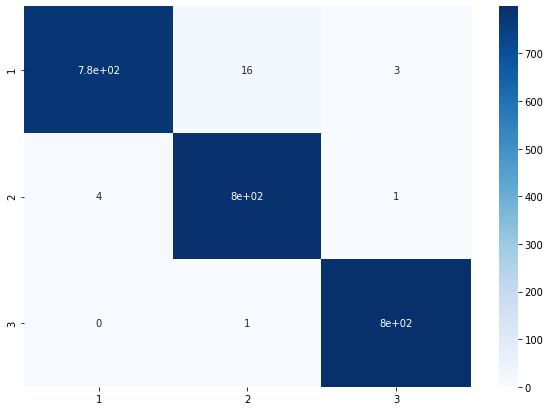

In [ ]:
cm_train = confusion_matrix(y_train_bool,y_train_pred_bool)
print("Training set confusion matrix:")
print(cm_train)
df_cm_test = pd.DataFrame(cm_train, index = char2int.keys(),
                  columns = char2int.keys())
%matplotlib inline
plt.figure(figsize = (10,7))
sn.heatmap(df_cm_test, annot=True, cmap = 'Blues')

Test set
[[ 99   0   1]
 [  0  99   1]
 [  0   0 100]]


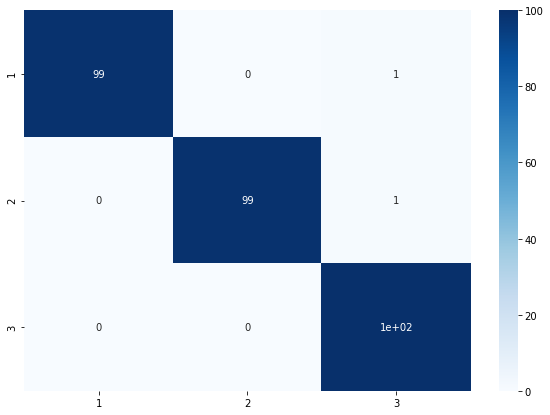

In [ ]:
cm_test = confusion_matrix(y_test_bool,y_test_pred_bool)
print("Test set confusion matrix:")
print(cm_test)
df_cm_test = pd.DataFrame(cm_test, index = char2int.keys(),
                  columns = char2int.keys())
%matplotlib inline
plt.figure(figsize = (10,7))
sn.heatmap(df_cm_test, annot=True, cmap = 'Blues')


# 4.Ensemble method

In [ ]:
# Save base models
idx = 2
model_name = path_out+"class_"+str(num_classes)+"_trainsize_"+str(trainsize)+"_model"+str(idx)+".h5"
model.save(model_name)

In [ ]:
# Load base models
model1 = load_model(path_out+"class_"+str(num_classes)+"_trainsize_"+str(trainsize)+"_model"+str(1)+".h5")
model2 = load_model(path_out+"class_"+str(num_classes)+"_trainsize_"+str(trainsize)+"_model"+str(2)+".h5")


In [ ]:
# create stacked model input dataset as outputs from the ensemble
def stacked_dataset(members, inputX):
  stackX = None
  for model in members:
    yhat = model.predict(inputX, verbose=0)
    yhat = pred_standard(yhat)
    if stackX is None:
      stackX = yhat
    else:
      stackX = np.dstack((stackX, yhat))
  stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]),order='F')
  return stackX

In [ ]:
# fit a model based on the outputs from the ensemble members
def fit_stacked_model(members, inputX, inputy):
  stackedX = stacked_dataset(members, inputX)
  model = LogisticRegression()
  print(stackedX.shape)
  print(inputy.shape)
  model.fit(stackedX, inputy)
  return model

In [ ]:
members = [model1,model2]
y_train_dec = label_binary_to_dec(y_train)
model_stack = fit_stacked_model(members, X_train, y_train_dec)

(2400, 6)
(2400,)


In [ ]:
y_test_dec = label_binary_to_dec(y_test)
stackedX_test = stacked_dataset(members, X_test)
stackedY_test = model_stack.predict(stackedX_test)
acc_test = accuracy_score(y_test_dec, stackedY_test)

stackedX_train = stacked_dataset(members, X_test)
stackedY_train = model_stack.predict(stackedX_test)
# acc_train = accuracy_score(y_train_dec, stackedY_train)

print(acc_test)
# print(acc_train)


0.9833333333333333


In [ ]:
# Define meta-model
from sklearn.ensemble import StackingClassifier

estimators = [('model1', model1),
              ('model2', model2)]

stack = StackingClassifier(estimators=estimators, final_estimator=None)
stack_history = stack.fit(X_train, label_binary_to_dec(y_train))
stack_acc = stack.score(X_test, label_binary_to_dec(y_test))
print(stack_acc)


ValueError: ignored

In [ ]:
# Train meta-model

In [ ]:
# Predict

In [ ]:
# Compare performance

# 5.Saliency map




In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 80, 80, 64)        1664      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
activation_9 (Activation)    (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 8, 8, 128)         204928    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 1, 1, 128)         0         
_________________________________________________________________
activation_10 (Activation)   (None, 1, 1, 128)         0         
_________________________________________________________________
reshape_7 (Reshape)          (None, 128)              

## Visualization with swapping softmax

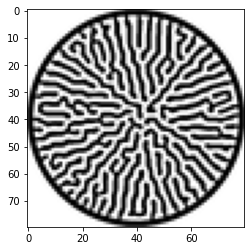

In [ ]:
# Show test image
class_idx = 0
indices = np.where(y_test[:, class_idx] == 1.)[0]
idx = indices[0]
plt.imshow(X_test[idx][..., 0],cmap='gray')
plt.show()

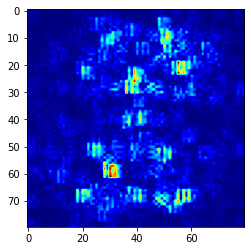

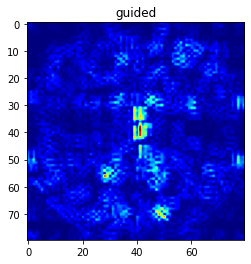

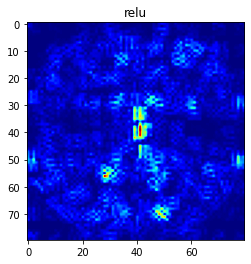

In [ ]:
# Guided saliency
for modifier in [None,'guided', 'relu']:
    grads = visualize_saliency(model, layer_idx,
                               filter_indices=class_idx,
                               seed_input=X_test[idx],
                               backprop_modifier=modifier)
    plt.figure()
    plt.title(modifier)
    plt.imshow(grads, cmap='jet')

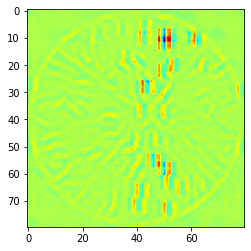

In [ ]:
# Negative gradient
grads = visualize_saliency(model, layer_idx,
                           filter_indices=class_idx,
                           seed_input=X_test[idx],
                           backprop_modifier='guided',
                           grad_modifier='negate')
plt.imshow(grads, cmap='jet')

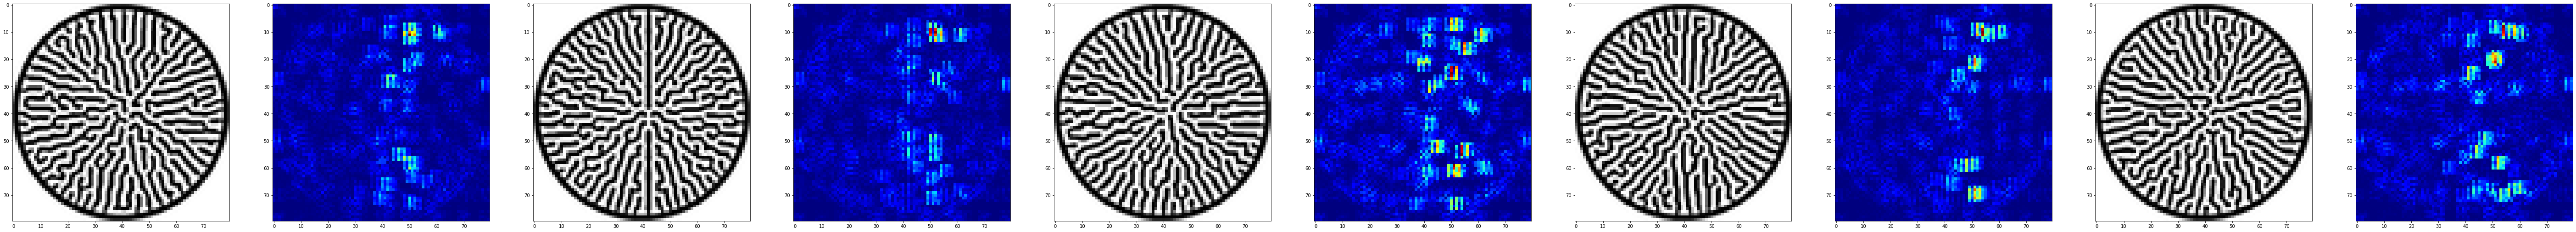

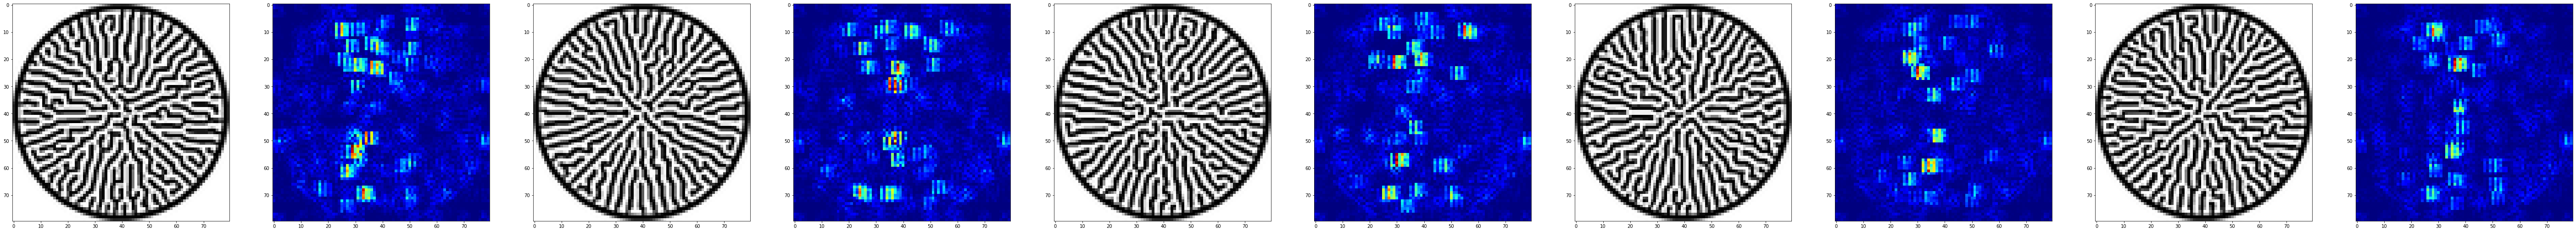

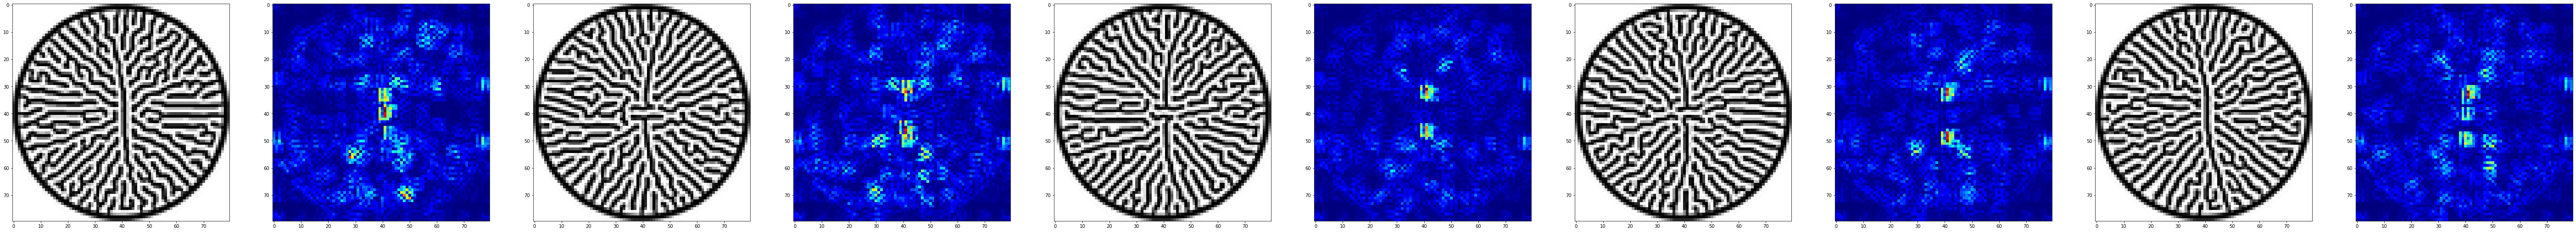

In [ ]:
# For all classes
model.layers[layer_idx].activation = activations.linear

# switch back to softmax
# model.layers[layer_idx].activation = activations.softmax

model = utils.apply_modifications(model)

for class_idx in np.arange(num_classes):
    indices = np.where(y_test[:, class_idx] == 1.)[0]
    num_rep = 5
    f, ax = plt.subplots(1, 2*num_rep, figsize=(100,100))

    for rep_idx in range(num_rep):
        idx = indices[rep_idx]
        grads = visualize_saliency(model, layer_idx, filter_indices=class_idx,
                                 seed_input=X_test[idx], backprop_modifier='guided')
        ax[rep_idx*2].imshow(X_test[idx][..., 0],cmap='gray')
        ax[rep_idx*2+1].imshow(grads, cmap='jet')

## grad-CAM


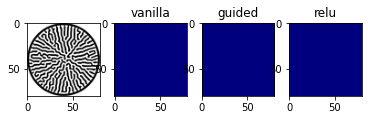

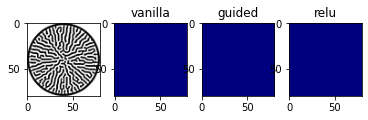

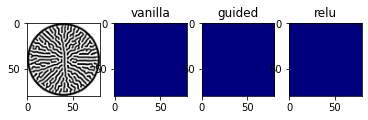

In [ ]:

# This corresponds to the Dense linear layer.
for class_idx in np.arange(num_classes):
    indices = np.where(y_test[:, class_idx] == 1.)[0]
    idx = indices[0]

    f, ax = plt.subplots(1, 4)
    ax[0].imshow(X_test[idx][..., 0],cmap='gray')

    for i, modifier in enumerate([None, 'guided', 'relu']):
        grads = visualize_cam(model, layer_idx, filter_indices=class_idx,
                              seed_input=X_test[idx], backprop_modifier=modifier)
        if modifier is None:
            modifier = 'vanilla'
        ax[i+1].set_title(modifier)
        ax[i+1].imshow(grads, cmap='jet')

# 6.Average saliency map

## Compute all saliency maps for dataset

In [ ]:
# Create folder to save saliency maps
!mkdir '/content/dataset/lib_3_r_5_spacing_15_noise_2_rep_1000/saliency_map'
path_saliency_map = '/content/dataset/lib_3_r_5_spacing_15_noise_2_rep_1000/saliency_map/'

mkdir: cannot create directory ‘/content/dataset/lib_3_r_5_spacing_15_noise_2_rep_1000/saliency_map’: File exists


In [ ]:
# Swap linear back with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

# get and save saliency map
for class_idx in np.arange(num_classes):
    indices = np.where(y_test[:, class_idx] == 1.)[0]
    num_rep = len(indices)
    for rep_idx in range(num_rep):
        idx = indices[rep_idx]
        grads = visualize_saliency(model, layer_idx, filter_indices=class_idx,
                                 seed_input=X_test[idx], backprop_modifier='guided')
        save_saliency_map(grads, idx, path)

## Averaged heatmap for each class

100%|██████████| 100/100 [00:00<00:00, 2517.98it/s]


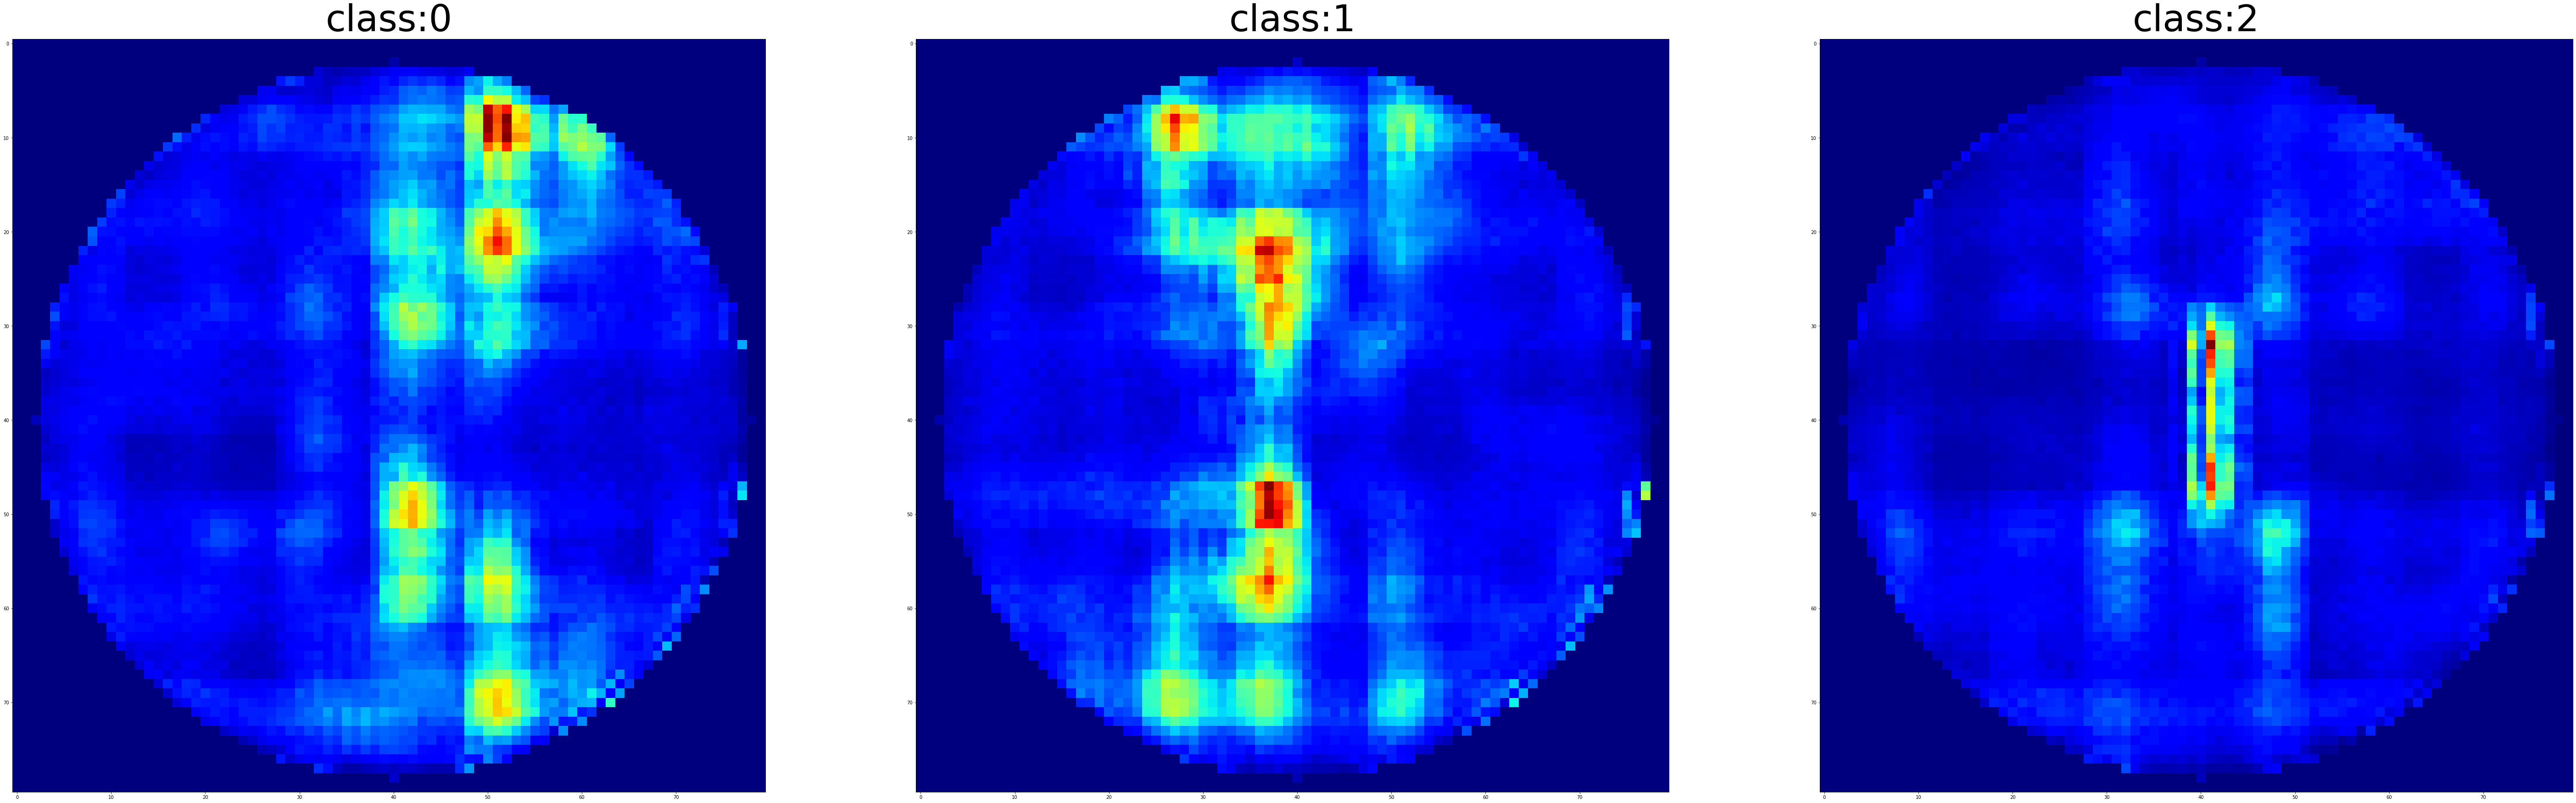

In [ ]:
fig,ax = plt.subplots(1,num_classes, figsize=(100,100))

for class_idx in np.arange(num_classes):
    indices = np.where(y_test[:, class_idx] == 1.)[0]
    num_rep = len(indices)
    sum_saliency_map = np.zeros((ResizedHeight,ResizedHeight))

    for rep_idx in tqdm(range(num_rep)):
        idx = indices[rep_idx]
        filename = path_saliency_map + "SM_ID_" + str(idx) + ".npy"
        saliency_map = np.load(filename)
        sum_saliency_map = sum_saliency_map + saliency_map

    ave_saliency_map = sum_saliency_map/num_rep
    # ave_saliency_map = ave_saliency_map*background_filter

    ax[class_idx].set_title('class:'+ str(class_idx), fontsize= 80)
    ax[class_idx].imshow(ave_saliency_map, cmap='jet')

    filename = path_saliency_map + "ave_SM_class_" + str(class_idx)
    np.save(filename, ave_saliency_map)

## Filter saliency map by intensity

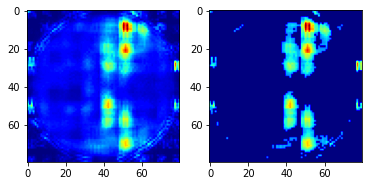

In [ ]:
# Filtered averaged heatmap
fig,ax = plt.subplots(1,2)
map_class = np.load(path_saliency_map + "ave_SM_class_" + str(0) + ".npy")
ax[0].imshow(map_class,cmap='jet')

map_class_filtered = map_class
map_class_filtered[map_class_filtered < 0.1] = 0
ax[1].imshow(map_class_filtered,cmap='jet')

## Averaged heatmap for all classes

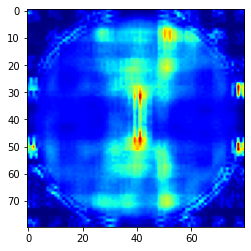

In [ ]:
sum_map = np.zeros((ResizedHeight,ResizedHeight))
for class_idx in range(num_classes):
    map_class = np.load(path_saliency_map + "ave_SM_class_" + str(class_idx) + ".npy")
    sum_map = sum_map + map_class
ave_map = sum_map/num_classes
plt.imshow(ave_map, cmap='jet')

## Common high excitation map

In [ ]:
# Vanilla filter of the plate area
temp = Image.open('/content/background.jpg')
background = temp.resize((ResizedHeight, ResizedHeight), Image.LANCZOS)
background_filter = np.asarray(background)
background_filter = background_filter/np.max(background_filter)

In [ ]:
# User defined filter
background_filter = create_circular_mask(ResizedHeight, ResizedHeight, radius=38)

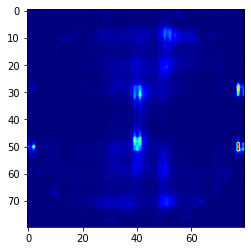

In [ ]:
# Normalized, filtered, common high excitation map
com_map = np.zeros((ResizedHeight,ResizedHeight))
map_list = []
idx_list = []
for class_idx in range(num_classes):
    map_class = np.load(path_saliency_map + "ave_SM_class_" + str(class_idx) + ".npy")
    map_list = map_list + [map_class]
    idx_list = idx_list + [(map_class > 0.1)]

com_map = map_list[0]* map_list[1]*map_list[2]
com_map = com_map*background_filter
com_map = com_map/np.amax(com_map)
plt.imshow(com_map,cmap='jet')